In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scikits.fitting as fit
%pylab inline

Populating the interactive namespace from numpy and matplotlib


##Load Data ##

Load some precalibrated single dish data.
* Tipping_power_data.dat  is the power in kelvens of the system
* Tipping_power_sigma_data.dat is the standard devation on the power
* Tipping_elevation_data.dat is the elevation values
* Tipping_freq_data.dat is the frequency values

Note: Only H-pol is provided

In [134]:
data = np.loadtxt("Tipping_power_data.dat")[:,:-6] # in Kelvin only HH pol    (elevation,freq)
sigma = np.loadtxt("Tipping_power_sigma_data.dat")[:,:-6]# sigma on the power (elevation,freq)
elev = np.loadtxt("Tipping_elevation_data.dat") # elevation in degrees from horizon
freq = np.loadtxt("Tipping_freq_data.dat")[:-6]   # frequency values in MHz

# Sky temperature

For the sky tempreture you can assume that it is the just the cmb tempreture

In [160]:
T_sky= np.zeros_like(data) # make the T_sky array full of zeros

raise RuntimeError('Please Enter CMB infomation')
T_sky += T_cmb


RuntimeError: Please Enter CMB infomation

##Plot data ##

Remove the source contamination seen at  50 to 54 elevation   
data points 31:35 by making a mask.

In [161]:
figure(figsize=(10,10))
freq_index = 23
mask = np.ones_like(elev,dtype=np.bool)

raise RuntimeError('Make a Mask')
plot(elev[mask],data[mask,freq_index])
title('Frequency = %s MHz'%(freq[freq_index]))

RuntimeError: Make a Mask

##Spillover models

Can be found here:

Temp_Spill.dat 


Temp_Spill.dat includes ground & atmospheric radiation pickup, the cosmic microwave background and an average Galactic noise of 20 K at 408 MHz, but the main beam and first sidelobe is zeroed out in the pattern integral. The ground is assumed to be in thermal equilibrium at 300 K with reflection approximated as the average of that of H & V. The atmosphere is modelled with the sky brightness model of Cortés-Medellín in SKA Memo 95, employing nominal values for atmospheric temperature, pressure and water vapour density which is believed to be representative of the Karoo environment except for winter time.


In [139]:
class Spill_Temp:
    """Load spillover models and interpolate to centre observing frequency."""
    def __init__(self,filename='./Temp_Spill.dat'):
        """ The class Spill_temp reads the spillover model from file and
        produces fitted functions for a frequency
        The class/__init__function takes in one parameter:
        filename : (default=none) This is the filename containing
               the spillover model ,this file has 3 cols:
               theta(Degrees, 0 at Zenith),tempreture (MHz),Frequency (MHz)
               if there are no files zero spilover is assumed.
               function save makes a file of the correct format
        returns :
               dict  spill with two elements 'HH' 'VV' that
               are intepolation functions that take in elevation & Frequency(MHz)
               and return tempreture in Kelven.
        """
        try:
            datafile =np.loadtxt(filename)
            elevation = datafile[1:,0]
            numfreqs = (datafile.shape[1]-1)//2
            freqs= datafile[0,1::2]
            elevation_list = np.array(())
            freq_list = np.array(())
            data_list = np.array(())
            elevation_list = np.r_[elevation_list,elevation]
            freq_list = np.r_[freq_list,np.ones_like(elevation)*800.0] ## Hard code the lower limit to avoid nans
            data_list = np.r_[data_list,datafile[1:,1+0*2]]
            for x in range(numfreqs):
                elevation_list = np.r_[elevation_list,elevation]
                freq_list = np.r_[freq_list,np.ones_like(elevation)*freqs[x]]
                data_list = np.r_[data_list,datafile[1:,1+x*2]]
                #print freqs[x]

            T_H = fit.Delaunay2DScatterFit() 
            T_H.fit((90.-elevation_list,freq_list),data_list)

            elevation_list = np.array(())
            freq_list = np.array(())
            data_list = np.array(())
            elevation_list = np.r_[elevation_list,elevation]
            freq_list = np.r_[freq_list,np.ones_like(elevation)*800.0]  ## Hard code the lower limit to avoid nans
            data_list = np.r_[data_list,datafile[1:,1+0*2+1]]
            for x in range(numfreqs):
                elevation_list = np.r_[elevation_list,elevation]
                freq_list = np.r_[freq_list,np.ones_like(elevation)*freqs[x]]
                data_list = np.r_[data_list,datafile[1:,1+x*2+1]]
            T_V = fit.Delaunay2DScatterFit()
            T_V.fit((90.-elevation_list,freq_list),data_list)
            self.spill = {}
            self.spill['HH'] = T_H # The HH and VV is a scape thing
            self.spill['VV'] = T_V
            #print self.spill['HH']((90.-elevation_list,freq_list))
   
        except IOError:
            spillover_H = np.array([[0.,90.,0.,90.],[0.,0.,0.,0.],[900.,900.,2000.,2000.]])
            spillover_V = np.array([[0.,90.,0.,90.],[0.,0.,0.,0.],[900.,900.,2000.,2000.]])
            spillover_H[0]= 90-spillover_H[0]
            spillover_V[0]= 90-spillover_V[0]
            T_H = fit.Delaunay2DScatterFit() 
            T_V = fit.Delaunay2DScatterFit()
            T_H.fit(spillover_H[[0,2],:],spillover_H[1,:])
            T_V.fit(spillover_V[[0,2],:],spillover_V[1,:])
            self.spill = {}
            self.spill['HH'] = T_H # The HH and VV is a scape thing
            self.spill['VV'] = T_V
            print ('Warning: Failed to load Spillover models, setting models to zeros')
            
        # the models are in a format of theta=0  == el=90


## Load the Spillover model ##

In [140]:
Spill_over = Spill_Temp('./Temp_Spill.dat')
spill = np.zeros_like(data)
for freq_index in range(freq.shape[0]) : 
    for elev_index in range(elev.shape[0]) : 
        spill[elev_index,freq_index] =  Spill_over.spill['HH']((np.array([[elev[elev_index],],[freq[freq_index]]]))) 

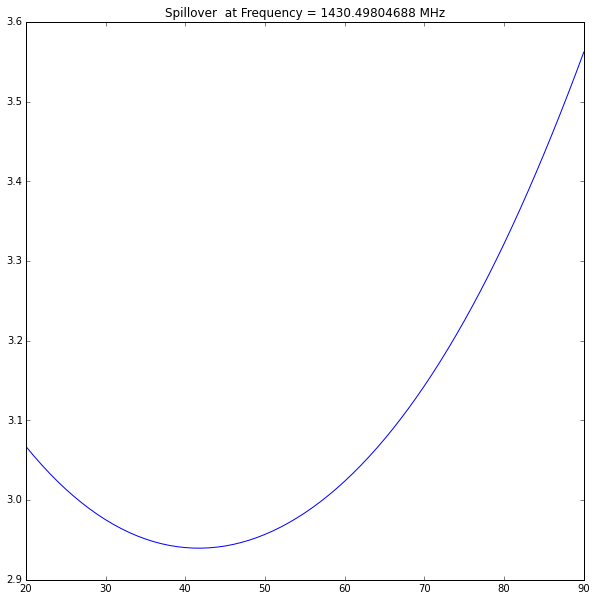

In [144]:
figure(figsize=(10,10))
freq_index = 23
plot(elev[:],spill[:,freq_index])
a = title('Spillover  at Frequency = %s MHz'%(freq[freq_index]))

#System Temperature

$T_{sys}(el) = T_{sky}(ra,dec)  + T_{atm}*(1-\exp(\frac{-\tau_{0}}{\sin(el)})) + T_{spill}(el) +  T_{rec}$

You will need to work out $T_{rec}$ &  $\tau_{0}$ from the data by fitting for the parameters ##



In [154]:
tau_0 = np.zeros_like(freq)
Temp_rec = np.zeros_like(freq)

In [162]:
surface_temperature = -273 # Deg C
raise RuntimeError('Put in the surface tempreture')
T_atm = 1.12 * (273.15 + surface_temperature) - 50.0  
for freq_index in range(freq.shape[0]) : 
    tipping_curve_func = None
    raise RuntimeError('Write a function that you ca fit the parameters to ')
    # Initialise the fitter with the function and an initial guess of the parameter values
    tip = fit.NonLinearLeastSquaresFit(tipping_curve_func, [70, 0.005]) # [T_rec = 70 K , tau_0 = 0.005] are starting values
    tip.fit(np.arange(np.shape(elev)[0])[mask], data[mask,freq_index])
    Temp_rec[freq_index] = tip.params[0]
    tau_0[freq_index] = tip.params[1]
#  results come from tip.params

freq_index = 23
print('T_rec = %.2f K  at %f MHz'  % (Temp_rec[freq_index],freq[freq_index]))
print('Zenith opacity tau_0 = %.5f' % (tau_0[freq_index],))


RuntimeError: Put in the surface tempreture

## Plot Tipping curve's derived bandpass response##

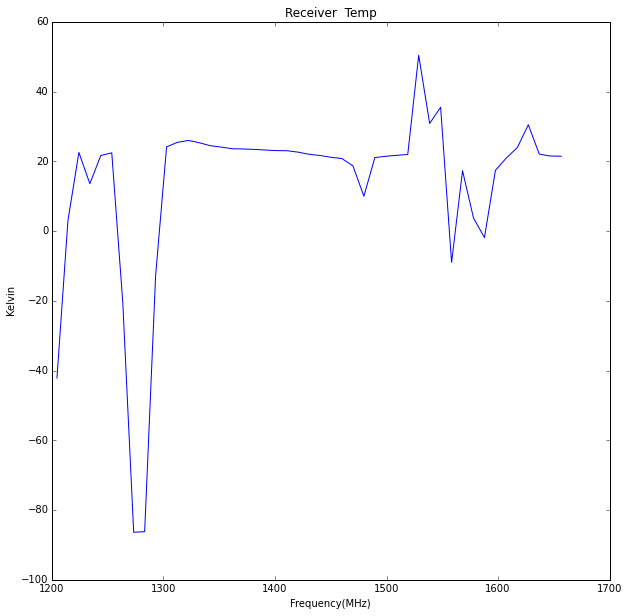

In [163]:
figure(figsize=(10,10))
plot(freq[:],Temp_rec[:])
ylabel('Kelvin')
xlabel('Frequency(MHz)')
a = title('Receiver  Temp ')

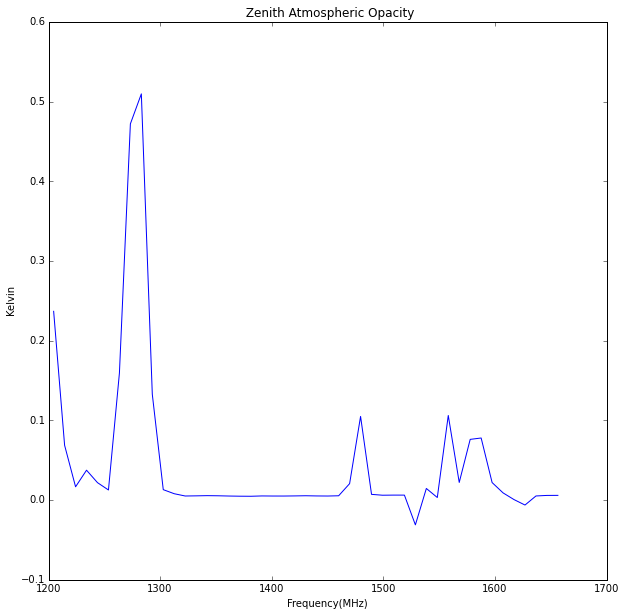

In [159]:
figure(figsize=(10,10))
freq_index = 23
plot(freq[:],tau_0[:])
ylabel('Kelvin')
xlabel('Frequency(MHz)')
a = title(' Zenith Atmospheric Opacity  ')

##Atmospheric opacity
Calculates zenith opacity according to ITU-R P.676-9. For elevations > 10 deg.<br>
        Used as $T_{atm}(1-\exp(\frac{-\tau_{0}}{\sin(el)}))$ for elevation dependence.<br>
        T: temperature in deg C<br>
        RH: relative humidity, 0 < RH < 1<br>
        P: dry air pressure in hPa (equiv. mbar)air pressure used insteead of dry air pressure<br> 
        h: height above sea level in km<br>
        f: frequency in GHz (must be < 55 GHz)<br>
        This function returns the return: approximate atmospheric opacity at zenith [Nepers]<br>
        
tau = calc_atmospheric_opacity(T_sys.surface_temperature,T_sys.air_relative_humidity, T_sys.pressure, T_sys.height/1000., freqs/1000.)


In [20]:
def calc_atmospheric_opacity(T, RH, P, h=1.035, f=1.4):
    """ 
        Calculates zenith opacity according to ITU-R P.676-9. For elevations > 10 deg.
        Use as "Tsky*(1-exp(-opacity/sin(el)))" for elevation dependence.
        T: temperature in deg C
        RH: relative humidity, 0 < RH < 1
        P: dry air pressure in hPa (equiv. mbar)
        h: height above sea level in km
        f: frequency in GHz (must be < 55 GHz)
        This function returns the return: approximate atmospheric opacity at zenith [Nepers]
    """
    es = 6.1121*np.exp((18.678-T/234.5)*T/(257.14+T)) # [hPa] from A. L. Buck research manual 1996
    rho = RH*es*216.7/(T+273.15) # [g/m^3] from A. L. Buck research manual 1996 (ITU-R ommited the factor "RH" - a mistake)
    
    # The following is taken directly from ITU-R P.676-9
    p_tot = P + es # from eq 3
    
    rho = rho*np.exp(h/2) # Adjust to sea level as per eq 32
    
    # eq 22
    r_t = 288./(273.+T)
    r_p = p_tot/1013.
    phi = lambda a, b, c, d: r_p**a*r_t**b*np.exp(c*(1-r_p)+d*(1-r_t))
    E_1 = phi(0.0717,-1.8132,0.0156,-1.6515)
    E_2 = phi(0.5146,-4.6368,-0.1921,-5.7416)
    E_3 = phi(0.3414,-6.5851,0.2130,-8.5854)
    # Following is valid only for f <= 54 GHz
    yo = ( 7.2*r_t**2.8 / (f**2+0.34*r_p**2*r_t**1.6) + 0.62*E_3 / ((54-f)**(1.16*E_1)+0.83*E_2) ) * f**2 * r_p**2 *1e-3
    # eq 23
    n_1 = 0.955*r_p*r_t**0.68 + 0.006*rho
    n_2 = 0.735*r_p*r_t**0.5 + 0.0353*r_t**4*rho
    g = lambda f, f_i: 1+(f-f_i)**2/(f+f_i)**2
    yw = (  3.98*n_1*np.exp(2.23*(1-r_t))/((f-22.235)**2+9.42*n_1**2)*g(f,22) + 11.96*n_1*np.exp(0.7*(1-r_t))/((f-183.31)**2+11.14*n_1**2)
          + 0.081*n_1*np.exp(6.44*(1-r_t))/((f-321.226)**2+6.29*n_1**2) + 3.66*n_1*np.exp(1.6*(1-r_t))/((f-325.153)**2+9.22*n_1**2)
          + 25.37*n_1*np.exp(1.09*(1-r_t))/(f-380)**2 + 17.4*n_1*np.exp(1.46*(1-r_t))/(f-448)**2
          + 844.6*n_1*np.exp(0.17*(1-r_t))/(f-557)**2*g(f,557) + 290*n_1*np.exp(0.41*(1-r_t))/(f-752)**2*g(f,752)
          + 8.3328e4*n_2*np.exp(0.99*(1-r_t))/(f-1780)**2*g(f,1780)
          ) * f**2*r_t**2.5*rho*1e-4
    
    # eq 25
    t_1 = 4.64/(1+0.066*r_p**-2.3) * np.exp(-((f-59.7)/(2.87+12.4*np.exp(-7.9*r_p)))**2)
    t_2 = 0.14*np.exp(2.12*r_p) / ((f-118.75)**2+0.031*np.exp(2.2*r_p))
    t_3 = 0.0114/(1+0.14*r_p**-2.6) * f * (-0.0247+0.0001*f+1.61e-6*f**2) / (1-0.0169*f+4.1e-5*f**2+3.2e-7*f**3)
    ho = 6.1/(1+0.17*r_p**-1.1)*(1+t_1+t_2+t_3)
    
    # eq 26
    sigma_w = 1.013/(1+np.exp(-8.6*(r_p-0.57)))
    hw = 1.66*( 1 + 1.39*sigma_w/((f-22.235)**2+2.56*sigma_w) + 3.37*sigma_w/((f-183.31)**2+4.69*sigma_w) + 1.58*sigma_w/((f-325.1)**2+2.89*sigma_w) )
    
    # Attenuation from dry & wet atmosphere relative to a point outside of the atmosphere
    A = yo*ho*np.exp(-h/ho) + yw*hw*np.exp(-h/hw) # [dB] from equations 27, 30 & 31
    
    return A*np.log(10)/10.0 # Convert dB to Nepers


The 'tipping curve' is calculated and evaluated using the expression below, with the free parameters of $T_{Rec}$ and $\tau_{0}$
the Receiver tempreture and the atmospheric opacity.

All the varables are also functions of frequency .<br>
$T_{sys}(el) = T_{cmb}(ra,dec)  + T_{atm}*(1-\exp(\frac{-\tau_{0}}{\sin(el)})) + T_{spill}(el) +T_{rec}$ <br>

The opacity can be calculated according to ITU-R P.676-9 or it can be fit for. <br>


#Main script flow

* Load the data
    * $T_{sky}$ calculation
    * Remove Data affected by Point source
* fit to the function to calculate to get the values of $T_{rec}$ and $\tau_0$ only the HH pol $T_{sys}$ is provided
* Plot a bandpass responce of the system
* Plot  $\tau_0$  and re values from the ITU-R P.676-9 model
    * Use the ITU-R P.676-9  atmospheric opacity model to get the values of $\tau_0$  and only fit for $T_{rec}$
    * Comment on RFI contamination as an effect on $T_{rec}$  Look at the GPS & GLONASS bands and AFRISTAR digital radio  frequencys



* Optional Question :
    * What was the peak flux density from the point source ( less cmb and receiver contrabutions )


Useful Infomation 
* The Telescope is  1035 Meters Above Sea Level
* The surface tempreture was 30.5 Degrees C.
* The relitive humidaty was 27 %
* Air pressure was 898.0 hPa (equiv. mbar)
* The Telescope has a dish of 12 meters in diameter


The 'tipping curve' is calculated according to the expression below,<br>
with the the parameters of $T_{rec}$ and $\tau_{0}$,<br>
the Antenna tempreture and the atmospheric opacity respectivly.<br>
All the varables are also functions of frequency.<br>
<br>
$T_{sys}(el) = T_{cmb}(ra,dec) + T_{gal}(ra,dec) + T_{atm}*(1-\exp(\frac{-\tau_{0}}{\sin(el)})) + T_{spill}(el) + 
+ T_{rec}$
<br><br>
 $\tau_{0}$, the zenith opacity,
<br>The function calc_atmospheric_opacity will calculate $\tau_{0}$, the zenith opacity,
 according to ITU-R P.676-9. <br>
$T_{rec}$ is the Receveier tempreture .<br>
